---------------------------------
## Misc Notes

### De-noising autoencoder for reproducing input images.   Testing on the faces/age dataset



In [1]:
import numpy as np
import os
import os.path
import pandas as pd
from pathlib import Path
import torch
from torch import nn, utils
import torch.nn.functional as F
import pytorch_lightning as pl
import torchvision
import matplotlib.pyplot as plt

from face_dataset import FaceDataset
from unet_1 import UNet_1

print('PyTorch version:', torch.__version__)
print('Torchvision version:', torchvision.__version__)
ngpu = torch.cuda.device_count()
print('Number of GPUs:', ngpu)

PyTorch version: 2.1.1+cu121
Torchvision version: 0.16.1+cu121
Number of GPUs: 2


In [ ]:
import numpy as np
import os
import os.path
import pandas as pd
from pathlib import Path
import torch
from torch import nn, utils
import torch.nn.functional as F
import pytorch_lightning as pl
import torchvision
import matplotlib.pyplot as plt

from face_dataset import FaceDataset
from unet_1 import UNet_1

print('PyTorch version:', torch.__version__)
print('Torchvision version:', torchvision.__version__)
ngpu = torch.cuda.device_count()
print('Number of GPUs:', ngpu)

PyTorch version: 2.1.1+cu121
Torchvision version: 0.16.1+cu121
Number of GPUs: 2


-----------------------------------------
## Face data

In [2]:
image_dir_train = Path('../data/age_data/20-50/train/')
image_dir_test = Path('../data/age_data/20-50/test/')

In [3]:
# Training data
filepaths_train = pd.Series(list(image_dir_train.glob(r'**/*.jpg')), name='Filepath', dtype = 'object').astype(str)
ages_train = pd.Series(filepaths_train.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age', dtype = 'object').astype(int)
images_train = pd.concat([filepaths_train, ages_train], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
print('Train data:', images_train.shape)
print(images_train.iloc[0])

# Training data
filepaths_test = pd.Series(list(image_dir_test.glob(r'**/*.jpg')), name='Filepath', dtype = 'object').astype(str)
ages_test = pd.Series(filepaths_test.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age', dtype = 'object').astype(int)
images_test = pd.concat([filepaths_test, ages_test], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
print('\nTest:', images_test.shape)
print(images_test.iloc[0])


Train data: (33432, 2)
Filepath    ../data/age_data/20-50/train/30/157170.jpg
Age                                                 30
Name: 0, dtype: object

Test: (7008, 2)
Filepath    ../data/age_data/20-50/test/20/37304.jpg
Age                                               20
Name: 0, dtype: object


In [4]:
class UnNormalize(object):
    def __init__(self) : #, mean, std):
        pass
        # self.mean = mean
        # self.std = std

    def __call__(self, img):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        # for t, m, s in zip(tensor, self.mean, self.std):
        # for t in (tensor):
        img = (img+0.5) * 255
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return img
    
unorm  = UnNormalize()

In [5]:
import torch
from torch import utils
import torch.nn.functional as F
from torchvision import transforms
import pytorch_lightning as pl
from torchvision.transforms.v2 import Resize, Compose, Normalize, ToDtype, RandomHorizontalFlip, RandomVerticalFlip 

img_size = (128,128) 
# mean = [0.50, 0.50, 0.50]
# std = [0.225, 0.225, 0.225]
batch_size = 128

train_transforms = Compose([ToDtype(torch.float32, scale=False),
                            RandomHorizontalFlip(p=0.25),
                            RandomVerticalFlip(p=0.25),
                            Resize(img_size, antialias=True) #,
                            ])

test_transforms = Compose([ToDtype(torch.float32, scale=False),
                           Resize(img_size, antialias=True),
                           ])

train_dataset = FaceDataset(image_dir_train, transform=train_transforms)
train_loader = utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=5, persistent_workers=True)

test_dataset = FaceDataset(image_dir_test, transform=test_transforms)
test_loader = utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = False, num_workers=5, persistent_workers=True)


Dataset has 33432 rows
Dataset has 7008 rows


torch.Size([3, 128, 128]) ,  torch.Size([3, 128, 128])
tensor(-0.4678) ,  tensor(0.5000)
torch.Size([3, 128, 128])
tensor(8, dtype=torch.uint8) ,  tensor(255, dtype=torch.uint8)


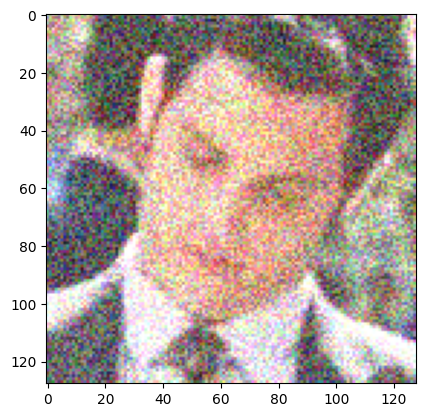

In [6]:
img, target = train_dataset.__getitem__(1)

print(img.shape, ', ', target.shape)
print(torch.min(img), ', ', torch.max(img))

uimg = unorm(img).to(torch.uint8)
print(uimg.shape)
print(torch.min(uimg), ', ', torch.max(uimg))
plt.imshow(uimg.permute(1, 2, 0))

torch.Size([128, 3, 128, 128]) ,  torch.Size([128, 3, 128, 128])
tensor(-0.5000) ,  tensor(0.5000)
num rows: 3 , num cols: 2


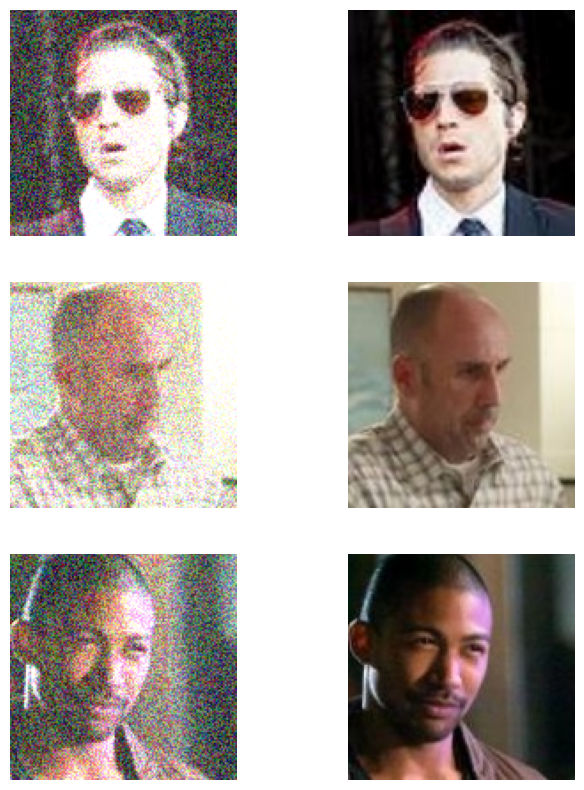

In [7]:
batch = next(iter(train_loader))
inputs, targets = batch
print(inputs.shape, ', ', targets.shape)
print(torch.min(inputs[0]), ', ', torch.max(inputs[0]))


cols = 2
rows = 3
print('num rows:', rows, ', num cols:', cols)
plt.figure(figsize=(8, 10))
idx = 0
for img, target in zip(inputs, targets):  
    img = unorm(img).to(torch.uint8).permute(1, 2, 0)
    target = unorm(target).to(torch.uint8).permute(1, 2, 0)

    idx += 1
    ax = plt.subplot(rows, cols, idx)
    ax.axis('off')
    plt.imshow(img)

    idx += 1
    ax = plt.subplot(rows, cols, idx)
    ax.axis('off')
    plt.imshow(target)

    if idx == (cols*rows):
        break

# plt.show()


---------------------
## The Lightning model

In [8]:
class AutoEncoder(pl.LightningModule):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.batch_size = 8
        self.learning_rate = 2e-3
        self.net = UNet_1() 
        self.net.apply(self._weights_init)
        self.criterion = torch.nn.MSELoss()  #torch.nn.BCELoss()
        
    @staticmethod
    def _weights_init(m):
        """
            Zero-centered distribution with std = 0.02
        """
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif classname.find("BatchNorm") != -1:
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)
    
    def __shared_step(self, batch):
        imgs, masks = batch
        preds = self.forward(imgs)
        loss = self.criterion(preds, masks)
        return loss
        
    def training_step(self, batch, batch_idx) :
        loss = self.__shared_step(batch)
        self.log("train_loss", loss, on_epoch=True, sync_dist=True) 
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.__shared_step(batch)
        self.log("val_loss", loss, on_epoch=True, sync_dist=True) 
        return loss
    
    def configure_optimizers(self):
        lr = 0.0002  
        betas = [0.5, 0.999] 
        opt = torch.optim.Adam(self.net.parameters(), lr=lr, betas=betas)
        return opt         
    


---------------
## Training

In [ ]:
# map_location = {'cuda:1':'cuda:0'}
# model = AutoEncoder.load_from_checkpoint(checkpoint_path='./lightning_logs/version_1/checkpoints/epoch=148-step=39038.ckpt',
#                                          map_location=map_location)

# model = AutoEncoder()

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=1,
    every_n_epochs=1,
    monitor = 'val_loss',
    mode = 'min'
)

from lightning.pytorch.loggers import TensorBoardLogger
logger = TensorBoardLogger(save_dir=os.getcwd(), name="lightning_logs")

trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=10000,
                     logger=logger, log_every_n_steps=10, callbacks=[checkpoint_callback]) 

# trainer = pl.Trainer(strategy="ddp_notebook", accelerator='gpu', devices=2, max_epochs=4000,
#                      logger=logger, log_every_n_steps=10, callbacks=[checkpoint_callback]) 


trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=test_loader) 

-----------------------------------------------
## Inference

In [9]:
model = AutoEncoder.load_from_checkpoint(checkpoint_path='./lightning_logs/version_2/checkpoints/epoch=295-step=77552.ckpt') 
model.eval()

AutoEncoder(
  (net): UNet_1(
    (up): Upsample(scale_factor=2.0, mode='bilinear')
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc_block_0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (enc_block_1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [10]:
iterator = iter(test_loader)

In [11]:
device = torch.device('cpu') #'cuda:0'
print('The model will be running on', device, 'device')
batch = next(iterator)
inputs, targets = batch
print(inputs.shape, ', ', targets.shape)
model.to(device)
logits = model(inputs)


The model will be running on cpu device
torch.Size([128, 3, 128, 128]) ,  torch.Size([128, 3, 128, 128])


num rows: 3 , num cols: 3


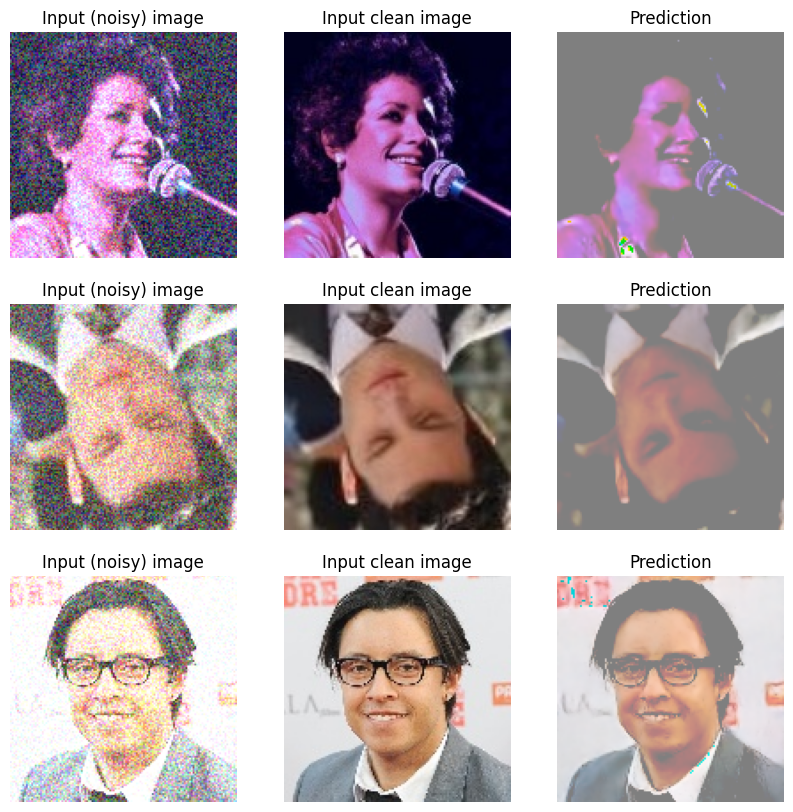

In [12]:
# Plot a grid of inference results.
unorm = UnNormalize()

cols = 3
rows = 3
print('num rows:', rows, ', num cols:', cols)
plt.figure(figsize=(10, 10))
idx = 0
for img, target, pred in zip(inputs, targets, logits):  
    img = unorm(img).to(torch.uint8).permute(1, 2, 0)
    target = unorm(target).to(torch.uint8).permute(1, 2, 0)
    pred = unorm(pred).to(torch.uint8).permute(1, 2, 0)

    idx += 1
    ax = plt.subplot(rows, cols, idx)
    ax.axis('off')
    ax.set_title('Input (noisy) image')
    plt.imshow(img)

    idx += 1
    ax = plt.subplot(rows, cols, idx)
    ax.axis('off')
    ax.set_title('Input clean image')
    plt.imshow(target)

    idx += 1
    ax = plt.subplot(rows, cols, idx)
    ax.axis('off')
    ax.set_title('Prediction')
    plt.imshow(pred)

    if idx == (cols*rows):
        break

